# 訓練流程：

1.訓練 mask rcnn 定位車牌

2.訓練 cnn 做單一的字體識別

3.分割車牌的 中文字 及 數字 及 英文數字

4.展示結果

5.最後 因分割車牌效果不佳 改用 tesseract 辨識

# 準備 Dataset

#### 1.載入 CCPD(Chinese City Parking Dataset) 

#### https://github.com/detectRecog/CCPD

#### The google drive link for directly downloading the whole dataset

#### https://drive.google.com/open?id=1fFqCXjhk7vE9yLklpJurEwP9vdLZmrJd2.

#### 2.用 VGG Image Annotator (VIA) to label images and get the .json file

#### 3.載入 Optical Character Recognition dataset

#### 4.clone https://github.com/matterport/Mask_RCNN

#### 5.載入 pretrain model mask_rcnn_coco.h5

# 1. Train Mask_RCNN model 
## (to locate car plate)

In [39]:
pwd

'/home/gtx1080/Downloads/car_plate_recognition'

In [40]:
import os
os.chdir('/home/gtx1080/Downloads/car_plate_recognition/Mask_RCNN')

In [41]:
pwd

'/home/gtx1080/Downloads/car_plate_recognition/Mask_RCNN'

### Train Model and use pretrain weight

In [42]:
%run carplate.py train --dataset=../dataset/carplate --weights=coco

Weights:  coco
Dataset:  ../dataset/carplate
Logs:  /home/gtx1080/Downloads/car_plate_recognition/Mask_RCNN/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.

Epoch 14/50
100/100 [==============================] - 93s 934ms/step - loss: 0.4630 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.3190 - val_loss: 1.2047 - val_rpn_class_loss: 0.0016 - val_rpn_bbox_loss: 0.2979 - val_mrcnn_class_loss: 0.0317 - val_mrcnn_bbox_loss: 0.2691 - val_mrcnn_mask_loss: 0.6044
Epoch 15/50
100/100 [==============================] - 93s 930ms/step - loss: 0.4376 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.3115 - val_loss: 1.4579 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.1149 - val_mrcnn_class_loss: 0.0369 - val_mrcnn_bbox_loss: 0.1403 - val_mrcnn_mask_loss: 1.1648
Epoch 16/50
100/100 [==============================] - 93s 930ms/step - loss: 0.5098 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.3423 - val_loss: 1.5778 - val_rp

<Figure size 432x288 with 0 Axes>

# 看 Mask_RCNN Model's 訓練結果

In [43]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import carplate

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to mask_rcnn trained weights
CARPLATE_WEIGHTS_PATH = "mask_rcnn_carplate_0050.h5"  

### Configuration

In [44]:
config = carplate.CarplateConfig()
CARPLATE_DIR = os.path.join(ROOT_DIR, "../dataset/carplate")

In [45]:

class InferenceConfig(config.__class__):

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

### Computer Inference

In [46]:
DEVICE = "/gpu:0"  

TEST_MODE = "inference"

In [47]:
def get_ax(rows=1, cols=1, size=16):

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Load Validation Dataset

In [48]:
dataset = carplate.CarplateDataset()
dataset.load_carplate(CARPLATE_DIR, "val")

dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'carplate']


### Load Model

In [49]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [50]:
weights_path = CARPLATE_WEIGHTS_PATH

In [51]:
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  mask_rcnn_carplate_0050.h5


### Run model to detect car license

image ID: carplate.粤BR75Y3.jpg (6) /home/gtx1080/Downloads/car_plate_recognition/Mask_RCNN/../dataset/carplate/val/粤BR75Y3.jpg


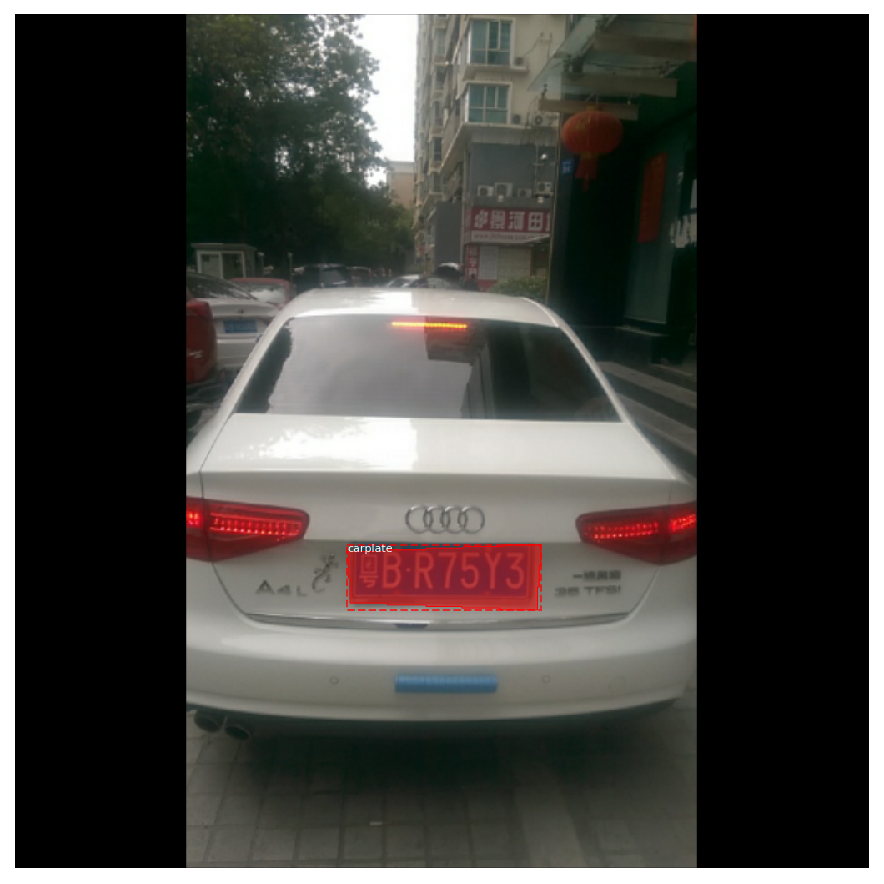

In [52]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  398.00000  max:  714.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


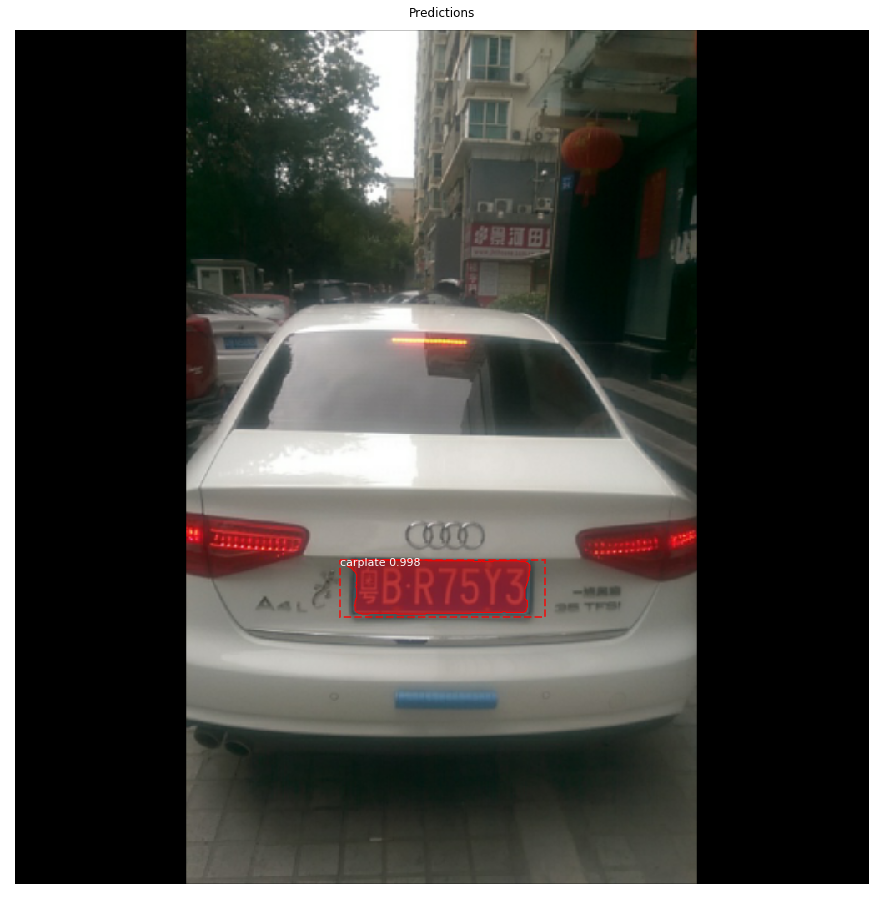

In [53]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# 2. Train CNN model 
### (to recognize Chinese Characters & Alphabet & Numbers)

In [54]:
import os
os.chdir('/home/gtx1080/Downloads/car_plate_recognition')

In [55]:
pwd

'/home/gtx1080/Downloads/car_plate_recognition'

In [56]:
import skimage.io
import skimage.color
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

### Load Dataset

In [57]:
DATASET_DIR = 'dataset/carplate'

classes = os.listdir(DATASET_DIR + "/ann/")
data = []

for cls in classes:
    files = os.listdir(DATASET_DIR + "/ann/"+cls)
    for f in files:
        img = skimage.io.imread(DATASET_DIR + "/ann/"+cls+"/"+f)
        img = skimage.color.rgb2gray(img)
        data.append({
            'x': img,
            'y': cls
        })

random.shuffle(data)

### Preprocessing Data

In [58]:
X = [d['x'] for d in data]
y = [d['y'] for d in data]

ys = list(np.unique(y))
y = [ys.index(v) for v in y]

x_train = np.array(X[:int(len(X)*0.8)])
y_train = np.array(y[:int(len(X)*0.8)])

x_test = np.array(X[int(len(X)*0.8):])
y_test = np.array(y[int(len(X)*0.8):])

In [59]:
batch_size = 128
num_classes = len(classes)
epochs = 10

# input image dimensions
img_rows, img_cols = 20, 20

In [60]:
def extend_channel(data):
    
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

x_train = extend_channel(x_train)
x_test = extend_channel(x_test)

input_shape = x_train.shape[1:]

In [61]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train2 = keras.utils.to_categorical(y_train, num_classes)
y_test2 = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (12920, 20, 20, 1)
12920 train samples
3231 test samples


### Build CNN Model

In [62]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [63]:
model.fit(x_train, y_train2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test2))

Train on 12920 samples, validate on 3231 samples
Epoch 1/10
12920/12920 [==============================] - 3s 219us/step - loss: 1.6708 - acc: 0.6047 - val_loss: 0.4001 - val_acc: 0.9161
Epoch 2/10
12920/12920 [==============================] - 1s 58us/step - loss: 0.4608 - acc: 0.8842 - val_loss: 0.1973 - val_acc: 0.9591
Epoch 3/10
12920/12920 [==============================] - 1s 50us/step - loss: 0.2945 - acc: 0.9254 - val_loss: 0.1366 - val_acc: 0.9687
Epoch 4/10
12920/12920 [==============================] - 1s 60us/step - loss: 0.2243 - acc: 0.9438 - val_loss: 0.1220 - val_acc: 0.9718
Epoch 5/10
12920/12920 [==============================] - 1s 59us/step - loss: 0.1932 - acc: 0.9494 - val_loss: 0.1108 - val_acc: 0.9759
Epoch 6/10
12920/12920 [==============================] - 1s 57us/step - loss: 0.1656 - acc: 0.9567 - val_loss: 0.1088 - val_acc: 0.9771
Epoch 7/10
12920/12920 [==============================] - 1s 48us/step - loss: 0.1463 - acc: 0.9626 - val_loss: 0.0983 - val_acc

In [64]:
model.save_weights('char_cnn.h5')

# 4. Combine All Model To Show Detection Result

In [5]:
pwd

'/home/gtx1080/Downloads/car_plate_recognition'

In [10]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN"))  
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import carplate

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


CARPLATE_WEIGHTS_PATH = "mask_rcnn_carplate_0050.h5"  

Using TensorFlow backend.


## Car plate location

In [11]:
config = carplate.CarplateConfig()
CARPLATE_DIR = os.path.join(ROOT_DIR, "dataset/carplate")

In [12]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

DEVICE = "/gpu:0"  

TEST_MODE = "inference"

In [13]:
def get_ax(rows=1, cols=1, size=16):

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [14]:
# Load validation dataset
dataset = carplate.CarplateDataset()
dataset.load_carplate(CARPLATE_DIR, "val")

dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 50
Classes: ['BG', 'carplate']


In [15]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Load the weight that trained in section 1

In [16]:
# Load weights
weights_path = CARPLATE_WEIGHTS_PATH
print("Loading weights", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights mask_rcnn_carplate_0050.h5


## Show original label photo 

image ID: carplate.浙A13840.jpg (25) /home/gtx1080/Downloads/car_plate_recognition/dataset/carplate/val/浙A13840.jpg


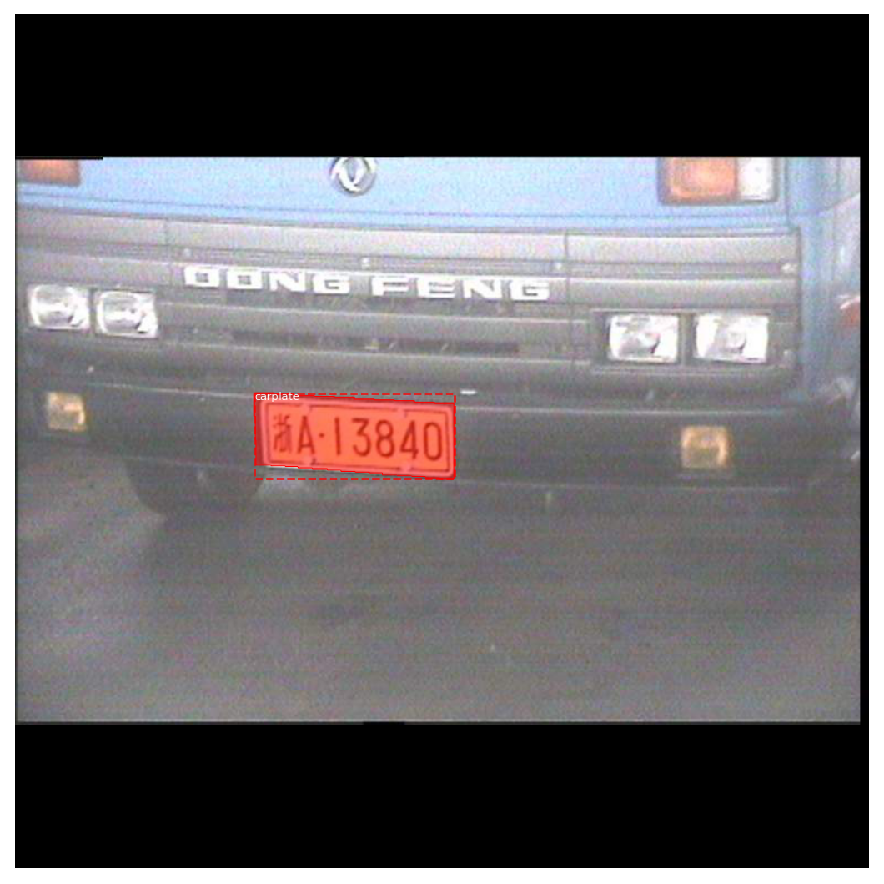

In [22]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

info = dataset.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names)

## Show the Mask RCNN Model Training Result

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


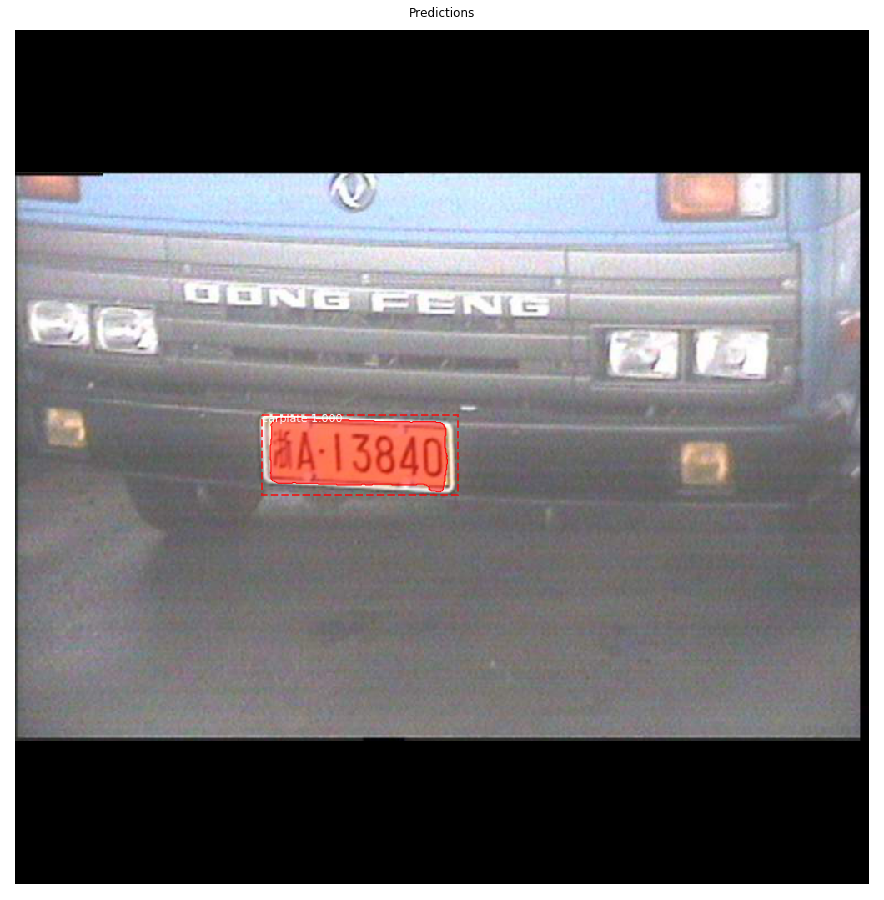

In [23]:
results = model.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [24]:
p = r['masks'].flatten()
p0 = np.where(p == True)[0][0]
p1 = np.where(p == True)[0][-1]

In [25]:
x0 = p0//image.shape[0]
y0 = p0%image.shape[0]
x1 = p1//image.shape[0]
y1 = p1%image.shape[0]

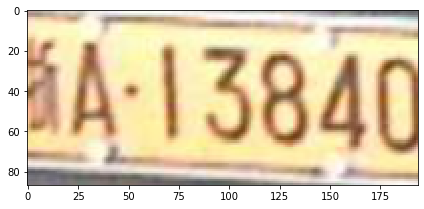

In [26]:
skimage.io.imshow(image[x0:x1, y0:y1])

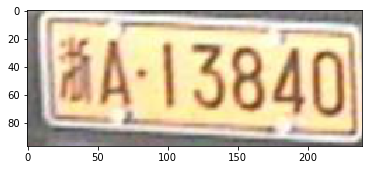

In [27]:
save_img = image[x0-5:x1+5, y0-30:y1+15]
plt.imshow(save_img)
plt.show()

In [28]:
plt.imsave('/home/gtx1080/Downloads/car_plate_recognition/ocr_data/1.png', save_img)

# 3. Split the words (字符分割)

In [29]:
img = image[x0:x1, y0:y1]

In [30]:
def split_x(img):
    skimage.io.imshow(img)
    ban = []
    last_i = 0
    for i in range(img.shape[1]):
        c = np.count_nonzero(img[:, i] < .3)
        if c > img.shape[0]*.8:
            if i - last_i > 3:
                plt.plot([last_i,last_i], [0,img.shape[0]], c='yellow')
                plt.plot([i,i], [0,img2.shape[0]], c='green')
                ban.append((last_i,i))

            last_i = i
    if i != last_i:
        plt.plot([last_i,last_i], [0,img.shape[0]], c='yellow')
        plt.plot([i,i], [0,img.shape[0]], c='green')
        ban.append((last_i,i))

    chars = []
    for y0, y1 in ban:
        img_sub = img[:, y0:y1]
        chars.append(img_sub)
    return chars

def split_y(img):
    plt.figure()
    skimage.io.imshow(img)
    
    last_i = 0
    ban = []
    for i in range(img.shape[0]):
        c = np.count_nonzero(img[i,:] < .3)
        if c > img.shape[1]*.9:
            if i - last_i > 3:
                plt.plot([0, img.shape[1]],[last_i,last_i], c='yellow')
                plt.plot([0, img.shape[1]],[i,i], c='green')
                ban.append((last_i, i))
            last_i = i
    if i != last_i:
        plt.plot([0, img.shape[1]],[last_i,last_i], c='yellow')
        plt.plot([0, img.shape[1]],[i,i], c='green')
        ban.append((last_i, i))
    
    for r0, r1 in ban:
        if r1 - r0 < img.shape[0]/3:
            continue

        img2 = img[r0:r1,:]
        s_max = max(img2.shape)

        pad_w = int((s_max - img2.shape[0])/2)
        pad_h = int((s_max - img2.shape[1])/2)

        img2 = np.pad(img2, ((pad_w,pad_w), (pad_h,pad_h)), mode='constant', constant_values=np.mean(img))
        img2 = skimage.transform.resize(img2, (20,20), mode='reflect', anti_aliasing=True)
        
        return img2

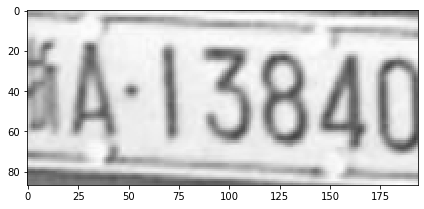

In [31]:
img2 = skimage.color.rgb2gray(img)
skimage.io.imshow(img2)

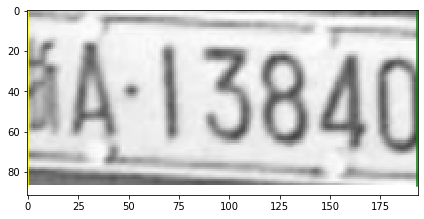

In [32]:
chars = split_x(img2)

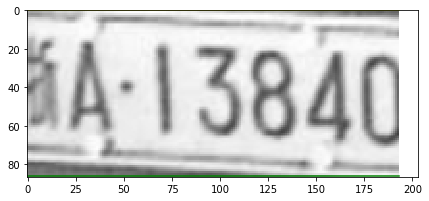

In [33]:
chars2 = np.array([split_y(c) for c in chars])

# Using CNN to recognize the words

In [34]:
DATASET_DIR = 'dataset/carplate'
classes = os.listdir(DATASET_DIR + "/ann/")

num_classes = len(classes)
img_rows, img_cols = 20, 20

if K.image_data_format() == 'channels_first':
    input_shape = [1, img_rows, img_cols]
else:
    input_shape = [img_rows, img_cols, 1]

In [35]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [36]:
model.load_weights("char_cnn.h5")

In [37]:
def extend_channel(data):
    if K.image_data_format() == 'channels_first':
        data = data.reshape(data.shape[0], 1, img_rows, img_cols)
    else:
        data = data.reshape(data.shape[0], img_rows, img_cols, 1)
        
    return data

### 因字符分割效果不佳 導致CNN辨識效果不好

In [38]:
ys = np.unique(classes)

p_test = model.predict_classes(extend_channel(chars2))
print(' '.join([ys[p_test[i]] for i in range(len(p_test))]))

zh_hei


# 5. Using OCR to recognize the words

In [85]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

## Preprocessing Image by opencv

In [86]:
pic = cv2.imread('/home/gtx1080/Downloads/car_plate_recognition/ocr_data/1.png')
pic = cv2.resize(pic, (520, 250), interpolation=cv2.INTER_CUBIC) # resize
gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY) # to gray

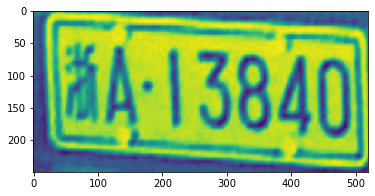

In [87]:
plt.imshow(gray)
plt.show()

## Use OCR model to detect the Chinese and English words

In [88]:
print(pytesseract.image_to_string((gray), lang='chi_sim+eng'))

狼13840


In [43]:
print(pytesseract.image_to_string((gray), lang='eng+chi_sim'))

ih: 13840


## Add different comfiguration of OCR to test

In [46]:
print(pytesseract.image_to_string((gray), lang='eng+chi_sim', config='--psm 7'))

[外 13840


In [47]:
print(pytesseract.image_to_string((gray), lang='eng+chi_sim', config='--psm 13'))

V4: 13840)
